# Biol 359  |  Linear Discriminant Analysis
### Spring 2021, Week 6

<hr style="border:2px solid gray"> </hr>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

sns.set(rc={'figure.figsize':(11.7,8.27)}) 
sns.set_style("white")

#### Import breast cancer data 
Optional reference: https://pandas.pydata.org/docs/index.html

In [2]:
from sklearn.datasets import load_breast_cancer
# NOTE:
# `breast_raw.data`: Stores the raw data (breast feature data)
# `breast_raw.feature_names`: Stores the raw data feature labels
# `breast_raw.target`: Stores the tumor type (0 = 'benign', 1 = 'malignant')
# `breast_raw.target_names`: Stores the tumor type labels ('benign' or 'malignant')
# `breast_raw.DESCR`: Description of the data
breast_raw = load_breast_cancer()

# Uncomment the following line to print a description of the data
print(breast_raw.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [3]:
# Feature data set
features = pd.DataFrame(breast_raw.data, columns=breast_raw.feature_names)
features.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# Tumor label data set
tumor = pd.DataFrame(breast_raw.target, columns=['tumor'])
# tumor_set.replace({'tumor type': {0: 'benign', 1: 'malignant'}}, inplace=True)
tumor.head()

,tumor
0,0
1,0
2,0
3,0
4,0


In [5]:
# Concantenate into one data frame
breast = pd.concat([features, tumor], axis=1)
# breast.loc[:, breast.columns != 'tumor'].head()
# breast.loc[:, breast.columns == 'tumor'].head()

#### Assess feature data statistics

In [6]:
features.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


### Plotting our data! 

In the case where we have 30 dimensions, we would have to make plots...below are four for an example of how we could plot each of the features against one another. 

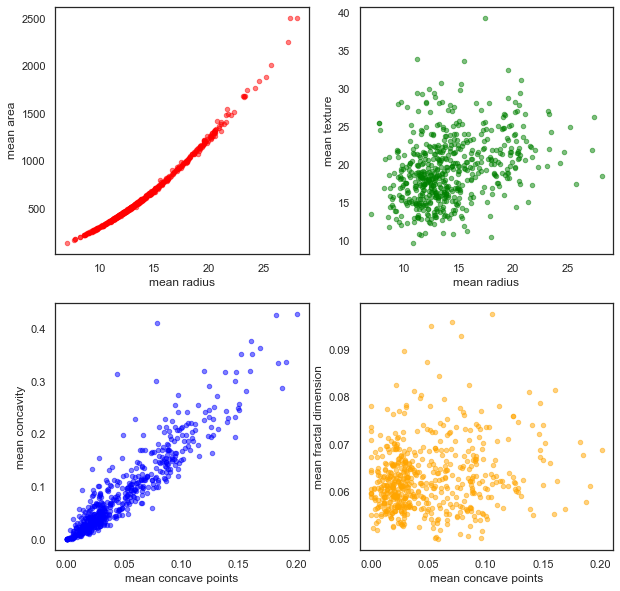

In [7]:
# Create scatter plots of the various features
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
features.plot.scatter(ax=axs[0, 0], x="mean radius", y="mean area", alpha=0.5, color='red');
features.plot.scatter(ax=axs[0, 1], x="mean radius", y="mean texture", alpha=0.5, color='green');
features.plot.scatter(ax=axs[1, 0], x="mean concave points", y="mean concavity", alpha=0.5, color='blue');
features.plot.scatter(ax=axs[1, 1], x="mean concave points", y="mean fractal dimension", alpha=0.5, color='orange');

### Another popular method is to use a Pair Plot. 
Do note that it makes it exceedingly difficult to make comparisons when your variables are on different plots.

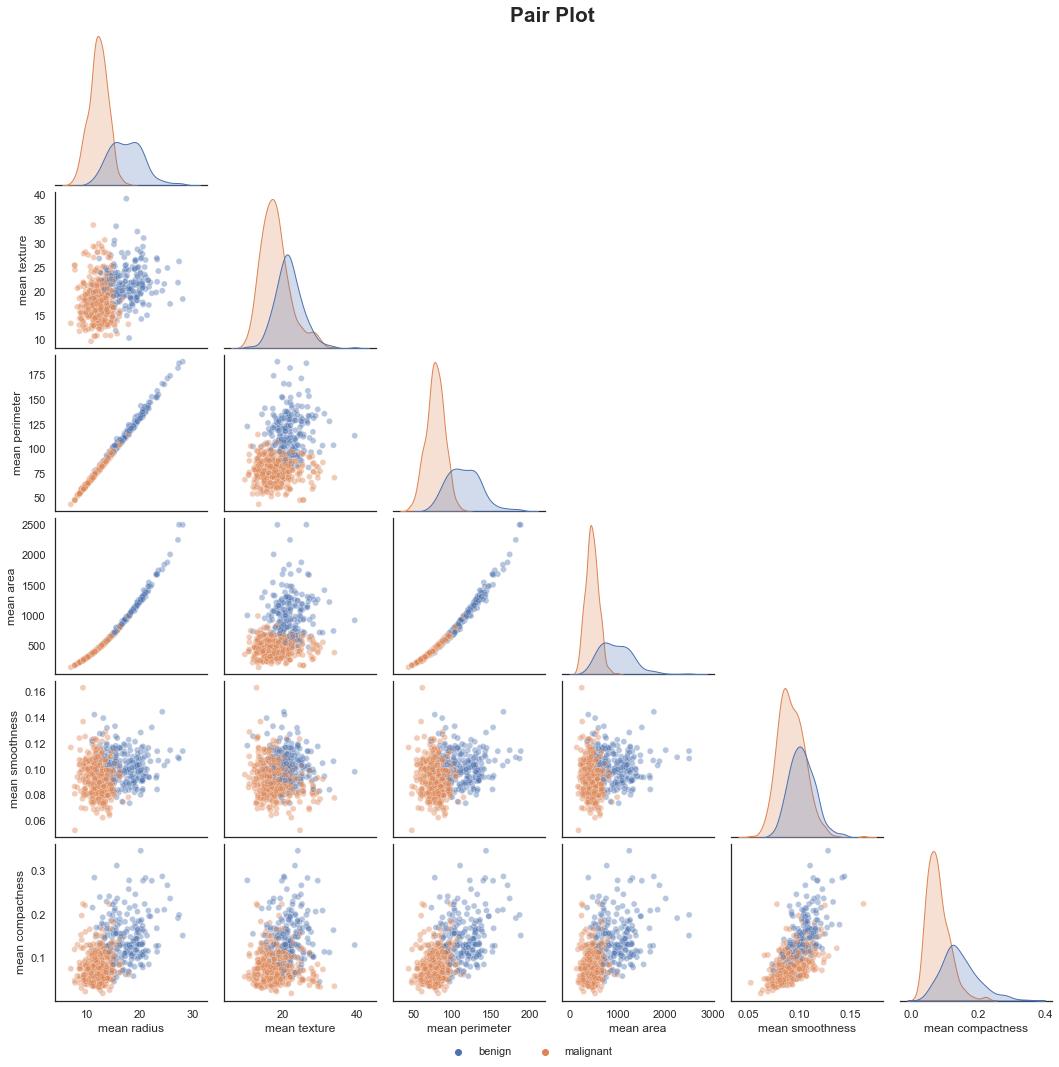

In [8]:
num_feats = 6
g = sns.pairplot(data=breast, corner=True, vars=features.columns.to_list()[0:num_feats], 
                 hue='tumor', plot_kws=dict(alpha=.4))

#you can ignore this
handles = g._legend_data.values()
g.fig.legend(handles=handles, loc='lower center', ncol=2, labels=['benign','malignant'], frameon=False)
g._legend.remove()
g.fig.suptitle('Pair Plot', weight='bold', size='xx-large')
g.fig.subplots_adjust(top=0.96, bottom=0.06)

### We can use PCA to identify axes (eigen vectors) that will retain the most information (variance) from our data:

In [9]:
# The code from last week did this from scratch, we are going to use a package from sklearn to do PCA this week
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def PerformPCA(X):
    """
    Uses sklearn PCA tool to perform PCA
    input:
    X: Pandas Dataframe or Numpy Array of features
    n_dimensions: Number of PCs to fit
    
    output:
    X_pca: Pandas dataframe with column titles of PC1,...,PCn
    """
    X_standardized = StandardScaler().fit_transform(X)
    pca = PCA()
    pca.fit(X_standardized)
    X_pca_array = pca.transform(X_standardized)
    column_names = ['PC{}'.format(i+1) for i in range(X_pca_array.shape[1])] 
    X_pca = pd.DataFrame(X_pca_array, columns=column_names)
    return X_pca, pca

pca_features, pca_results = PerformPCA(features)
pca_features

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
0,9.192837,1.948583,-1.123166,3.633731,-1.195110,1.411424,2.159370,-0.398407,-0.157118,-0.877402,...,0.096515,0.068850,0.084519,-0.175256,-0.151020,-0.201503,-0.252585,-0.033914,0.045648,-0.047169
1,2.387802,-3.768172,-0.529293,1.118264,0.621775,0.028656,0.013358,0.240988,-0.711905,1.106995,...,-0.077327,-0.094578,-0.217718,0.011290,-0.170510,-0.041129,0.181270,0.032624,-0.005687,-0.001868
2,5.733896,-1.075174,-0.551748,0.912083,-0.177086,0.541452,-0.668166,0.097374,0.024066,0.454275,...,0.311067,-0.060309,-0.074291,0.102762,0.171158,0.004735,0.049569,0.047026,0.003146,0.000751
3,7.122953,10.275589,-3.232790,0.152547,-2.960878,3.053422,1.429911,1.059565,-1.405440,-1.116975,...,0.434193,-0.203266,-0.124105,0.153430,0.077496,-0.275225,0.183462,0.042484,-0.069295,-0.019937
4,3.935302,-1.948072,1.389767,2.940639,0.546747,-1.226495,-0.936213,0.636376,-0.263805,0.377704,...,-0.116545,-0.017650,0.139454,-0.005332,0.003062,0.039254,0.032168,-0.034786,0.005038,0.021214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,6.439315,-3.576817,2.459487,1.177314,-0.074824,-2.375193,-0.596130,-0.035471,0.987929,0.256989,...,0.006888,-0.067000,0.088590,0.107898,0.219520,-0.122900,0.159198,0.009853,0.007119,-0.001415
565,3.793382,-3.584048,2.088476,-2.506028,-0.510723,-0.246710,-0.716326,-1.113360,-0.105207,-0.108632,...,-0.009802,0.019563,-0.055405,0.086135,0.001197,0.065889,-0.068512,-0.023575,-0.027486,-0.010419
566,1.256179,-1.902297,0.562731,-2.089227,1.809991,-0.534447,-0.192758,0.341887,0.393917,0.520877,...,-0.036592,0.063352,-0.200312,-0.044819,0.002429,0.007095,-0.023691,-0.002578,0.006706,0.003770
567,10.374794,1.672010,-1.877029,-2.356031,-0.033742,0.567936,0.223082,-0.280239,-0.542035,-0.089296,...,0.140648,-0.042478,0.168820,-0.195969,0.377830,-0.198192,-0.027409,-0.068086,-0.084163,-0.023783


### Note: the PCs have been ordered from highest amount of variance explained to least: PC1 captures the most variance in the data.

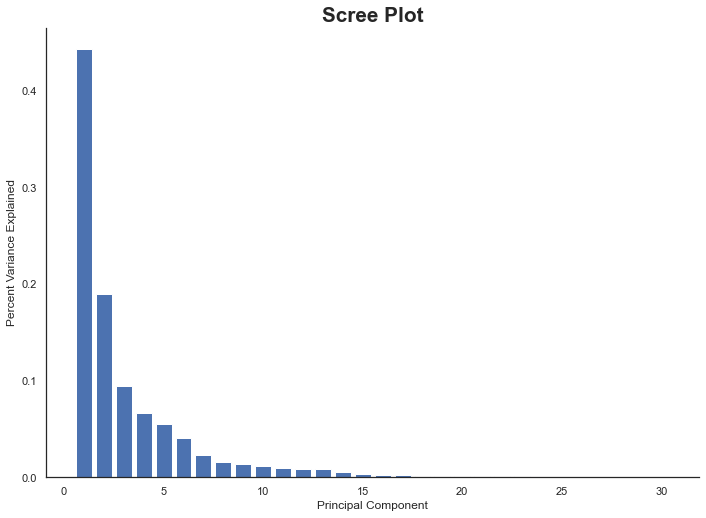

In [10]:
PC_values = np.arange(pca_results.n_components_) + 1
plt.bar(PC_values, pca_results.explained_variance_ratio_);
plt.title("Scree Plot", weight='bold', size='xx-large' )
plt.xlabel("Principal Component")
plt.ylabel("Percent Variance Explained")
sns.despine()
plt.show()

### Can you see the diminishing returns in how many principle components to include?

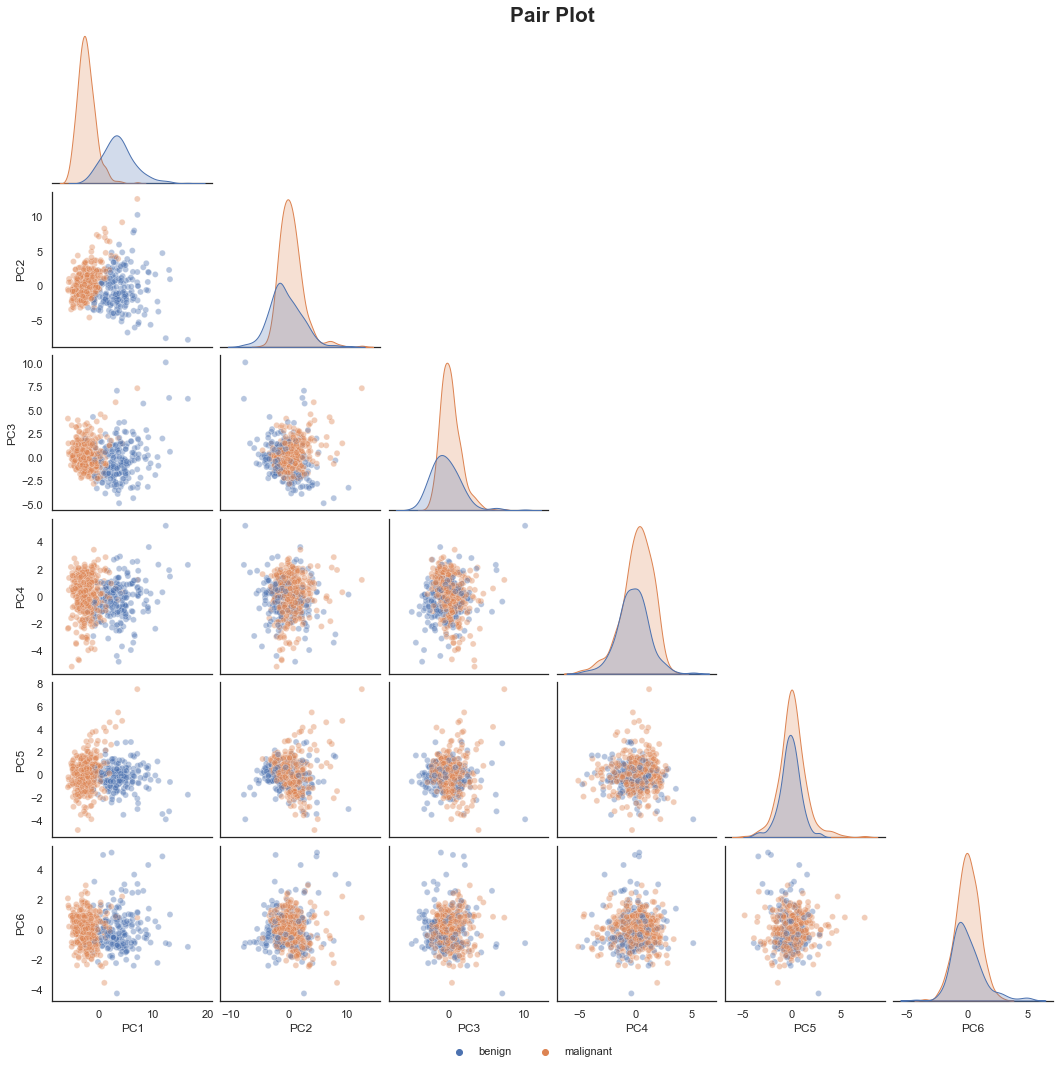

In [11]:
pca_breast = pd.concat([pca_features, tumor], axis=1)

num_feats = 6
g = sns.pairplot(data=pca_breast, corner=True, vars=pca_features.columns.to_list()[0:num_feats], 
                 hue='tumor', plot_kws=dict(alpha=.4))

#you can ignore this
handles = g._legend_data.values()
g.fig.legend(handles=handles, loc='lower center', ncol=2, labels=['benign','malignant'], frameon=False)
g._legend.remove()
g.fig.suptitle('Pair Plot', weight='bold', size='xx-large')
g.fig.subplots_adjust(top=0.96, bottom=0.06)

### Since we can capture most of the variance in our data from simply using PC1 and PC2, we can make a 2D plot with that information:

Be careful with your interpretations here, we haven't necessarily done an analysis, we have just **perspective** that we are looking at the data from.

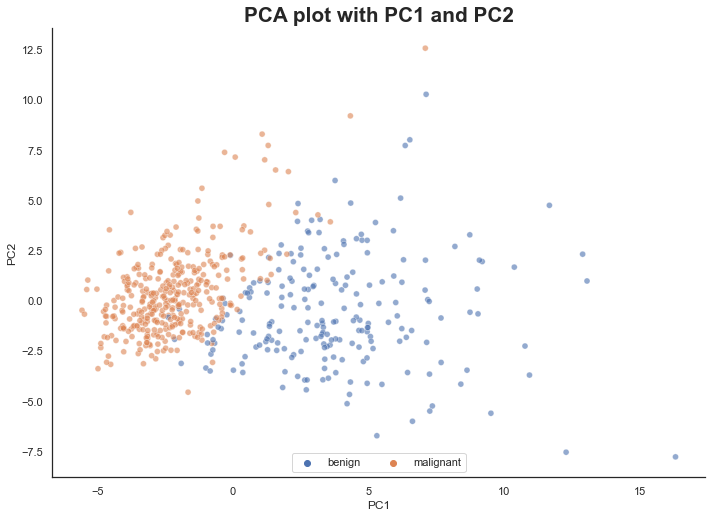

In [12]:
g = sns.scatterplot(data=pca_breast, x='PC1', y='PC2', hue='tumor', alpha=.6)
sns.despine()
#you can ignore this
handles, _ = g.get_legend_handles_labels()
g.legend(handles=handles, loc='lower center', ncol=2, labels=['benign','malignant'])
plt.title('PCA plot with PC1 and PC2', weight='bold', size='xx-large')
plt.show()

### Remember, PCA is unsupervised:
Unsupervised means that we did **not** include any information about the benign vs. malignant information. 
What if our goal was to seperate the two classes or identify new data?
What if we tried to use that information to inform our new axes?

**Let's move on to Linear Discriminant Analysis**

### Supervised Learning: 

If unsupervised learning was to help us indentify **patterns** in the data we couldn't otherwise see, supervised learning is used for making **predictions** about our data. What if we had a new tumor sample that we have measured using the same metrics that we have identified before (*e.g.* mean area, mean concavity), could we use our previous data to predict malignancy? 

Let's use Linear Discriminant Analysis to try and make these predictions, and as you will see, it has some similar utility to PCA. We will project our features onto a new dimension, trying to seperate our classes: benign and maliganant.

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def PerformLDA(X, y):
    """
    Uses sklearn LinearDiscriminantAnalysis tool to perform LDA
    input:
    X: Pandas Dataframe or Numpy Array of features
    y: Pandas Series or Numpy Vector of target 
    n_dimensions: Number of LDs to fit
    
    output:
    X_lda: Pandas dataframe with column titles of LD1,...,LDn
    """
    X_standardized = StandardScaler().fit_transform(X)
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_standardized,y)
    X_lda_array = lda.transform(X_standardized)
    column_names = ['LD{}'.format(i+1) for i in range(X_lda_array.shape[1])] 
    X_lda = pd.DataFrame(X_lda_array, columns=column_names)
    return X_lda, lda

lda_features, lda_results = PerformLDA(features, tumor)
lda_breast = lda_features.join(tumor)
lda_features

,LD1
0,-3.323927
1,-2.319108
2,-3.747425
3,-4.048549
4,-2.281158
...,...
564,-4.525468
565,-2.928588
566,-0.968062
567,-5.879643


### Now that we've reduced the dimensionality with LDA, let's compare it visually to PCA. 

These 4 plots show the exact same data, but it might be easier to interpret one over another. Feel free to draw your conclusions from any of them (and maybe think about what conclusions are easier to draw from what visualizations!) 

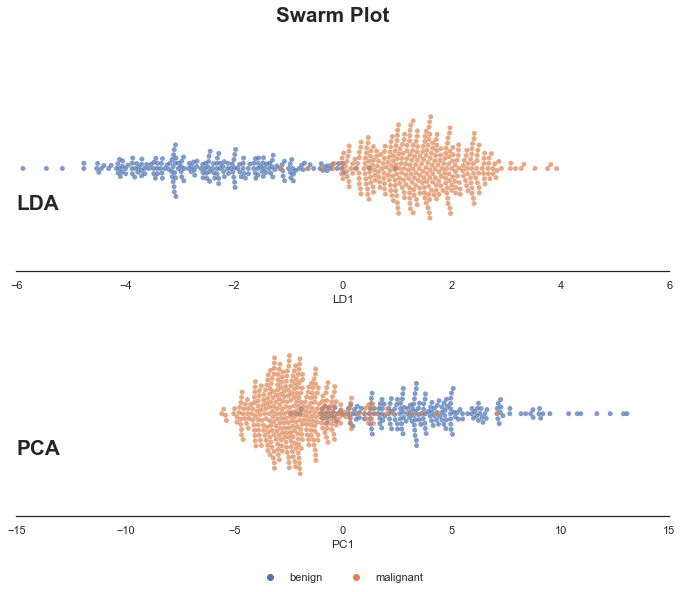

In [14]:
fig, axs = plt.subplots(2)
sns.swarmplot(ax=axs[0], data=lda_breast[lda_breast['tumor']==0], x='LD1', color=sns.color_palette()[0], alpha=.7)
sns.swarmplot(ax=axs[0], data=lda_breast[lda_breast['tumor']==1], x='LD1', color=sns.color_palette()[1], alpha=.7)
sns.despine(left=True)
sns.swarmplot(ax=axs[1], data=pca_breast[pca_breast['tumor']==0], x='PC1', color=sns.color_palette()[0], alpha=.7)
sns.swarmplot(ax=axs[1], data=pca_breast[pca_breast['tumor']==1], x='PC1', color=sns.color_palette()[1], alpha=.7)
sns.despine(left=True)
axs[0].text(-6, .2, 'LDA', weight='bold', size='xx-large')
axs[1].text(-15, .2, 'PCA', weight='bold', size='xx-large')
axs[0].set_xlim(-6,6)
axs[1].set_xlim(-15,15)
fig.legend(handles=handles, loc='lower center', ncol=2, labels=['benign','malignant'], frameon=False)
fig.suptitle('Swarm Plot', weight='bold', size='xx-large')
plt.show()



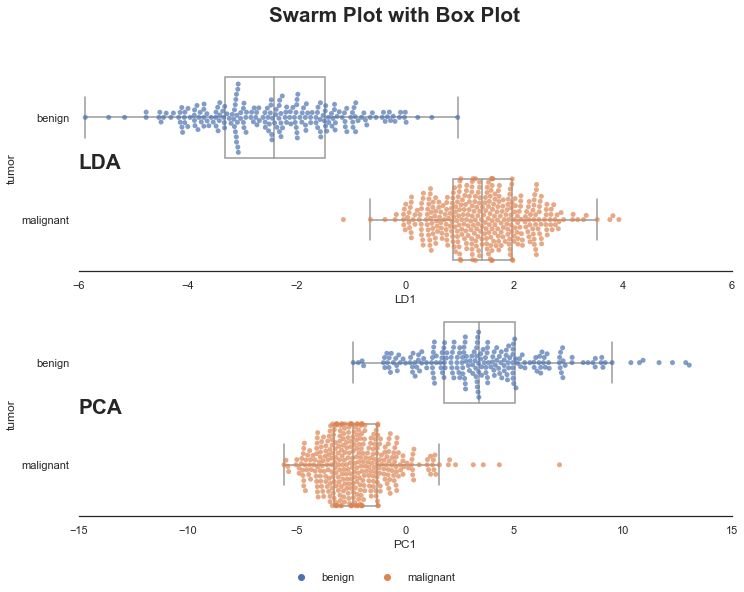

In [15]:
fig, axs = plt.subplots(2)

sns.boxplot(ax=axs[0], data=lda_breast.replace({'tumor': {0: 'benign', 1: 'malignant'}}), 
              x='LD1', y='tumor', color='white', fliersize=0)
sns.swarmplot(ax=axs[0], data=lda_breast.replace({'tumor': {0: 'benign', 1: 'malignant'}}), 
              x='LD1', y='tumor', alpha=.7)

sns.despine(left=True)
sns.boxplot(ax=axs[1], data=pca_breast.replace({'tumor': {0: 'benign', 1: 'malignant'}}), 
              x='PC1', y='tumor', color='white', fliersize=0)
sns.swarmplot(ax=axs[1], data=pca_breast.replace({'tumor': {0: 'benign', 1: 'malignant'}}), 
              x='PC1', y='tumor', alpha=.7)
sns.despine(left=True)
axs[0].text(-6, .5, 'LDA', weight='bold', size='xx-large')
axs[1].text(-15, .5, 'PCA', weight='bold', size='xx-large')
axs[0].set_xlim(-6,6)
axs[1].set_xlim(-15,15)
fig.legend(handles=handles, loc='lower center', ncol=2, labels=['benign','malignant'], frameon=False)
fig.suptitle('Swarm Plot with Box Plot', weight='bold', size='xx-large')
plt.show()


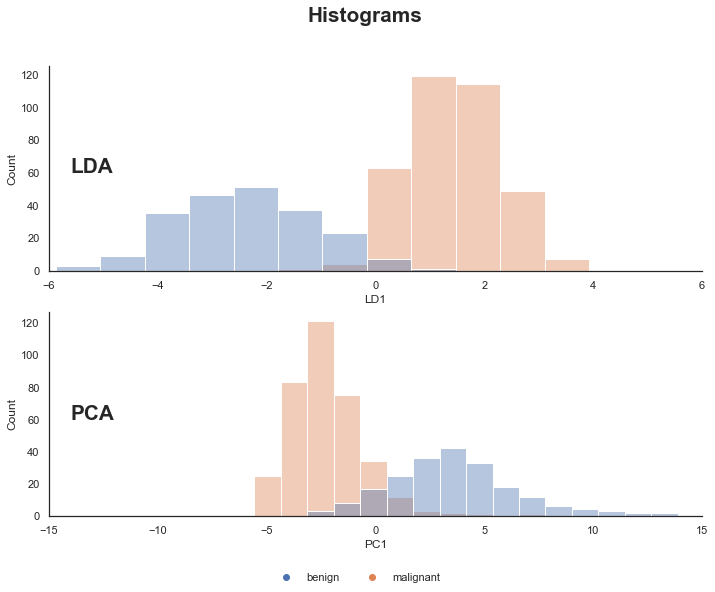

In [16]:
fig, axs = plt.subplots(2)
sns.histplot(ax=axs[0], data=lda_breast, x='LD1', hue='tumor', alpha=.4, fill=True, legend=False)
sns.despine()
sns.histplot(ax=axs[1], data=pca_breast, x='PC1', hue='tumor', alpha=.4, fill=True, legend=False)
sns.despine()
axs[0].text(-5.6, 60, 'LDA', weight='bold', size='xx-large')
axs[1].text(-14, 60, 'PCA', weight='bold', size='xx-large')
axs[0].set_xlim(-6,6)
axs[1].set_xlim(-15,15)
fig.legend(handles=handles, loc='lower center', ncol=2, labels=['benign','malignant'], frameon=False)
fig.suptitle('Histograms', weight='bold', size='xx-large')
plt.show()



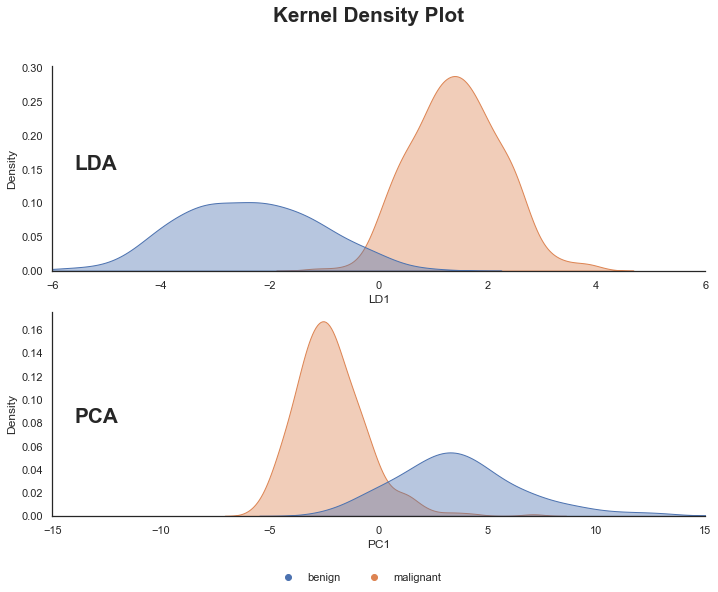

In [17]:
fig, axs = plt.subplots(2)
sns.kdeplot(ax=axs[0], data=lda_breast, x='LD1', hue='tumor', alpha=.4, fill=True, legend=False)
sns.despine()
sns.kdeplot(ax=axs[1], data=pca_breast, x='PC1', hue='tumor', alpha=.4, fill=True, legend=False)
sns.despine()
axs[0].text(-5.6, .15, 'LDA', weight='bold', size='xx-large')
axs[1].text(-14, .08, 'PCA', weight='bold', size='xx-large')
axs[0].set_xlim(-6,6)
axs[1].set_xlim(-15,15)
fig.legend(handles=handles, loc='lower center', ncol=2, labels=['benign','malignant'], frameon=False)
fig.suptitle('Kernel Density Plot', weight='bold', size='xx-large')
plt.show()

### Now let's try to use LDA to predict whether or not a tumor is benign or malignant. 

First we will split our data into an 80% training set and a 20% test set. 

In [18]:
from sklearn.model_selection import train_test_split

split = 0.2

X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(features), 
                                                    tumor, test_size=split, random_state=5)

print(f"My training set has {X_train.shape[0]} observations, where my test set has {X_test.shape[0]}.")

My training set has 455 observations, where my test set has 114.


### How can we evaluate our classification? 

An ubiquitous metric is "accuracy" which is the percentage of the set (training or test) that the algorithm was able to predict correctly. The training set is the data where the algorithm "sees" the target/response class. The test set is the one where we withhold the class data until the algorithm makes the prediction.

Remember: we have the ground truth of benign v. malignant to compare to, and we just need to give the algorithm the features. Please do be critical of any biases for your ground truth data, as your algorithm will only be as effective as the data you provide.

In [19]:
def PerformLDA(X, y):
    """
    Uses sklearn LinearDiscriminantAnalysis tool to perform LDA
    input:
    X: Pandas Dataframe or Numpy Array of features
    y: Pandas Series or Numpy Vector of target 
    n_dimensions: Number of LDs to fit
    
    output:
    X_lda: Pandas dataframe with column titles of LD1,...,LDn
    """
    X_standardized = StandardScaler().fit_transform(X)
    lda = LinearDiscriminantAnalysis()
    lda.fit(X,y)
    X_lda_array = lda.transform(X)
    column_names = ['LD{}'.format(i+1) for i in range(X_lda_array.shape[1])] 
    X_lda = pd.DataFrame(X_lda_array, columns=column_names)
    return X_lda, lda

lda_train, lda_model = PerformLDA(X_train, y_train)
train_accuracy = lda_model.score(X_train, y_train)
print(f"Training classification accuracy of {train_accuracy*100:0.1f}%")
test_accuracy = lda_model.score(X_test, y_test)
print(f"Test classification accuracy of {test_accuracy*100:0.1f}%")

Training classification accuracy of 96.5%
Test classification accuracy of 95.6%


In [20]:
lda_train

,LD1
0,2.068065
1,0.653824
2,-0.219317
3,2.175826
4,-2.279781
...,...
450,-1.891211
451,-0.273389
452,-3.208916
453,-3.701278


In [ ]:
train = pd.DataFrame(lda_model.transform(X_train), columns=['LD1'])
train['tumor'] = y_train.values
train['train'] = 'train'
test = pd.DataFrame(lda_model.transform(X_test), columns=['LD1'])
test['tumor'] = y_test.values
test['train'] = 'test'
test['predict'] = lda_model.predict(X_test)


total_set = pd.concat([train, test], ignore_index=True)
total_set = total_set.replace({'tumor': {0: 'benign', 1: 'malignant'}})
total_set = total_set.replace({'predict': {0: 'benign', 1: 'malignant'}})

sns.swarmplot(data=total_set, x='LD1', y='train', hue='tumor', hue_order=['benign','malignant'],alpha=.7)
# sns.swarmplot(data=total_set[total_set['guess']!=total_set['guess']], x='LD1', y='train', color='red', size=3, alpha=.2)
sns.despine()
misses=total_set[total_set['predict']!=total_set['tumor']].dropna()
plt.axvline(misses['LD1'].min(), linestyle='--', color='r', linewidth=1)
plt.axvline(misses['LD1'].max(), linestyle='--', color='r', linewidth=1)
plt.show()

In [ ]:
misses[['LD1','tumor','predict']]